In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import gaussian_filter
from scipy import signal

# PHYS 512 - Problem Set 4
Tristan Ménard<br>
260675783

### a) Noise model
First, load in the data from all events at both Livingston and Hanford.

In [2]:
# Read the LIGO data
directory = 'C:/Users/Trix/Documents/GitHub/phys512-problem-sets/ProblemSet4/LOSC_Event_tutorial/LOSC_Event_tutorial/'
# directory = 'C:/Users/trist/Documents/GitHub/phys512-problem-sets/ProblemSet4/LOSC_Event_tutorial/LOSC_Event_tutorial/'

def read_template(filename):
    dataFile = h5py.File(filename,'r')
    template = dataFile['template']
    th = template[0]
    tl = template[1]
    return th, tl

def read_file(filename):
    dataFile = h5py.File(filename, 'r')
    dqInfo = dataFile['quality']['simple']
    qmask = dqInfo['DQmask'][...]
    
    meta = dataFile['meta']
    gpsStart = meta['GPSstart'][()]
    utc = meta['UTCstart'][()]
    duration = meta['Duration'][()]
    strain = dataFile['strain']['Strain'][()]
    dt = (1.0*duration)/len(strain)
    
    dataFile.close()
    return strain, dt, utc

# Get the data from the following (ordered) files:
fnames_H = ['H-H1_LOSC_4_V2-1126259446-32.hdf5', 'H-H1_LOSC_4_V2-1128678884-32.hdf5', 'H-H1_LOSC_4_V2-1135136334-32.hdf5', 'H-H1_LOSC_4_V1-1167559920-32.hdf5']
fnames_L = ['L-L1_LOSC_4_V2-1126259446-32.hdf5', 'L-L1_LOSC_4_V2-1128678884-32.hdf5', 'L-L1_LOSC_4_V2-1135136334-32.hdf5', 'L-L1_LOSC_4_V1-1167559920-32.hdf5']
template_names = ['GW150914_4_template.hdf5', 'LVT151012_4_template.hdf5', 'GW151226_4_template.hdf5', 'GW170104_4_template.hdf5']

# fnames_H = ['H-H1_LOSC_4_V1-1167559920-32.hdf5', 'H-H1_LOSC_4_V2-1126259446-32.hdf5', 'H-H1_LOSC_4_V2-1128678884-32.hdf5', 'H-H1_LOSC_4_V2-1135136334-32.hdf5']
# fnames_L = ['L-L1_LOSC_4_V1-1167559920-32.hdf5', 'L-L1_LOSC_4_V2-1126259446-32.hdf5', 'L-L1_LOSC_4_V2-1128678884-32.hdf5', 'L-L1_LOSC_4_V2-1135136334-32.hdf5']
# template_names = ['GW170104_4_template.hdf5', 'GW150914_4_template.hdf5', 'LVT151012_4_template.hdf5', 'GW151226_4_template.hdf5']

# Initialize some arrays of the correct size to hold the data
# Each array holds one of the following: Hanford strain, Livingston strain, Hanford template, Livingston template
# They should all have the same size
strain_tmp, dt, utc = read_file(directory+fnames_H[0])
strain_H = np.zeros([len(fnames_H), len(strain_tmp)])
strain_L = strain_H.copy()
th = strain_H.copy()
tl = strain_L.copy()

# We already imported the strain from Hanford for the first event
strain_H[0,:] = strain_tmp
# Now load in the others
for i in range(1,len(fnames_H)):
    strain_tmp, dt, utc = read_file(directory+fnames_H[i])
    strain_H[i,:] = strain_tmp
    
# Do the same for the Livingston strain, and the templates
for i in range(0,len(fnames_L)):
    strain_tmp, dt, utc = read_file(directory+fnames_L[i])
    strain_L[i,:] = strain_tmp
    th_tmp, tl_tmp = read_template(directory+template_names[i])
    th[i,:] = th_tmp
    tl[i,:] = tl_tmp
    
# Get the sampling rate:
fs = 1/dt
print('The sampling rate is', fs, 'Hz')

The sampling rate is 4096.0 Hz


I separately estimate the noise model for each instrument to be the to be the square of the absolute value of the Fourier transform of the data from the event. Each strain should be windowed, and I have chosen to use a Hanning window for this purpose. Also, I have chosen to use a gaussian filter to smooth the noise models.

In [3]:
def noise_model(strain):
    # Estimate the noise model as the power spectrum
    # PS = |FT(strain)|^2
    # But need to window the data to reduce edge-effects resulting from the Fourier transform
    # So nultiply the strain by a Hanning window before taking the Fourier transform
    noise_win = np.abs(np.fft.rfft(strain*np.hanning(len(strain))))**2
    
    # Smooth the noise model using a gaussian filter
    noise_smooth = gaussian_filter(noise_win, 3)
    return noise_smooth

Now, I can use this function to get the noise models for each instrument and each gravitational wave detection.

In [4]:
# Hanford noise models for each GW event
noise1_H = noise_model(strain_H[0,:])
noise2_H = noise_model(strain_H[1,:])
noise3_H = noise_model(strain_H[2,:])
noise4_H = noise_model(strain_H[3,:])
noise_H = np.array([noise1_H, noise2_H, noise3_H ,noise4_H])
# Livingston noise models for each GW event
noise1_L = noise_model(strain_L[0,:])
noise2_L = noise_model(strain_L[1,:])
noise3_L = noise_model(strain_L[2,:])
noise4_L = noise_model(strain_L[3,:])
noise_L = np.array([noise1_L, noise2_L, noise3_L, noise4_L])

# Get the corresponding frequencies from the Fourier transformation of the time vector
freq = np.fft.rfftfreq(len(strain_H[0,:]), dt)

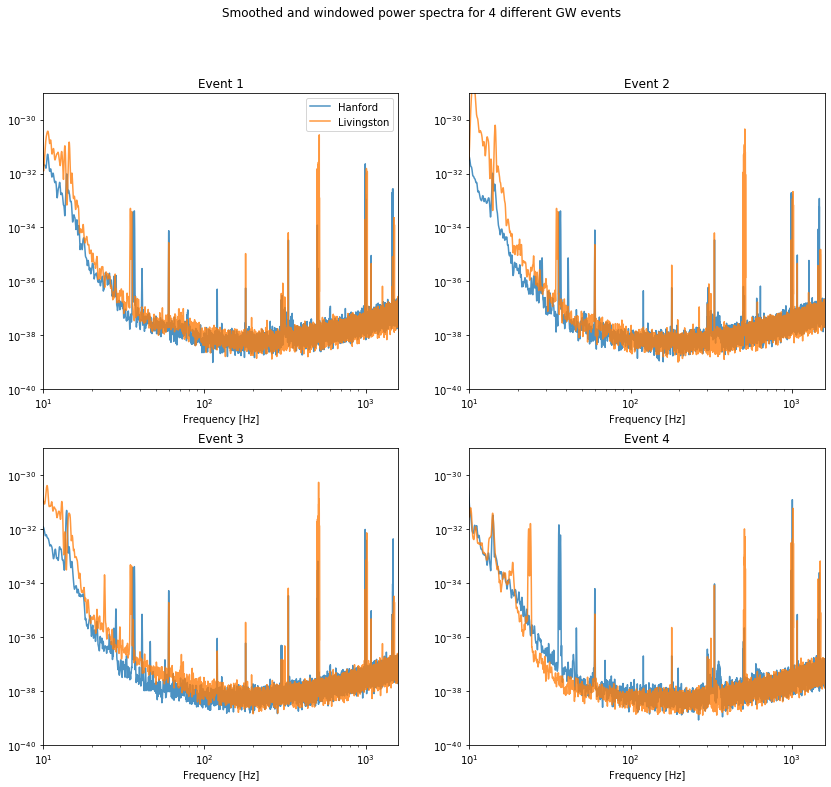

In [5]:
# Plot the noise models from both instruments for each gravitational wave detection
fig, ax = plt.subplots(2, 2, figsize=(14,12))
fig.suptitle('Smoothed and windowed power spectra for 4 different GW events')

ax[0,0].set_title('Event 1')
ax[0,0].loglog(freq, noise1_H, alpha=0.8)
ax[0,0].loglog(freq, noise1_L, alpha=0.8)
ax[0,0].set_xlabel('Frequency [Hz]')
ax[0,0].axis([10,1600,1e-40,1e-29])
ax[0,0].legend(['Hanford','Livingston'])

ax[0,1].set_title('Event 2')
ax[0,1].loglog(freq, noise2_H, alpha=0.8)
ax[0,1].loglog(freq, noise2_L, alpha=0.8)
ax[0,1].set_xlabel('Frequency [Hz]')
ax[0,1].axis([10,1600,1e-40,1e-29])

ax[1,0].set_title('Event 3')
ax[1,0].loglog(freq, noise3_H, alpha=0.8)
ax[1,0].loglog(freq, noise3_L, alpha=0.8)
ax[1,0].set_xlabel('Frequency [Hz]')
ax[1,0].axis([10,1600,1e-40,1e-29])

ax[1,1].set_title('Event 4')
ax[1,1].loglog(freq, noise4_H, alpha=0.8)
ax[1,1].loglog(freq, noise4_L, alpha=0.8)
ax[1,1].set_xlabel('Frequency [Hz]')
ax[1,1].axis([10,1600,1e-40,1e-29])
plt.show()

### b) Searching for gravitational waves with a matched filter
The matched filter is used to maximize the SNR and find the time location of the gravitational wave event. Before getting the matched filter, we must do a little bit of signal processing: (1) window the strain and template; and (2) whiten the strain and the template. Then, the matched filter is simply given by

$$
\text{MF} = \text{IFT}(\text{FT}(N^{-1/2}A)^* \text{FT}(N^{-1/2}d))
$$

where $\text{FT}(N^{-1/2}A)^*$ is the complex conjugate of the Fourier transform of the whitened template and $\text{FT}(N^{-1/2}d)$ is the Fourier transform of the whitened strain.

In [6]:
# Define a function that returns the whitened form of some signal (either a strain or a template).
def whiten(data, noise):
    data_ft = np.fft.rfft(data)
    data_white_ft = data_ft/np.sqrt(noise)
    data_white = np.fft.irfft(data_white_ft)
    return data_white

In [7]:
def matched_filter(strain, template, noise):
    # Signal processing techniques: apply a Hanning window, whiten, then get the Fourier transform of the whitened signal.
    strain_win = strain*np.hanning(len(strain))
    strain_white = whiten(strain_win, noise)
    strain_white_ft = np.fft.rfft(strain_white)
    
    # Do the same for the tempalte:
    template_win = template*np.hanning(len(strain))
    template_white = whiten(template_win, noise)
    template_white_ft = np.fft.rfft(template_white)
    
    # Calculate the matched filter
    matched_filter = np.fft.irfft(np.conj(template_white_ft).T*strain_white_ft)
    
    return matched_filter

In [8]:
# Hanford matched filters for each GW event
mf_H_1 = matched_filter(strain_H[0,:], th[0,:], noise1_H)
mf_H_2 = matched_filter(strain_H[1,:], th[1,:], noise2_H)
mf_H_3 = matched_filter(strain_H[2,:], th[2,:], noise3_H)
mf_H_4 = matched_filter(strain_H[3,:], th[3,:], noise4_H)
# Livingston matched filters for each GW event
mf_L_1 = matched_filter(strain_L[0,:], tl[0,:], noise1_L)
mf_L_2 = matched_filter(strain_L[1,:], tl[1,:], noise2_L)
mf_L_3 = matched_filter(strain_L[2,:], tl[2,:], noise3_L)
mf_L_4 = matched_filter(strain_L[3,:], tl[3,:], noise4_L)

# Get the corresponding time vector
time = np.arange(0, len(strain_H[0,:])*dt, dt)
time_shifted = np.fft.fftshift(time)

# Get indices where we have the best match between the strain and the template
idxs_H = []
idxs_L = []
for mf in [mf_H_1, mf_H_2, mf_H_3, mf_H_4]:
    idxs_H.append(np.where(np.abs(mf) == np.abs(mf).max())[0][0])
for mf in [mf_L_1, mf_L_2, mf_L_3, mf_L_4]:
    idxs_L.append(np.where(np.abs(mf) == np.abs(mf).max())[0][0])

In [9]:
def plot_matched_filter(ax, time, matched_filter_H, matched_filter_L, title, peak_H_idx, peak_L_idx, axlim=[0,32,-5,3.2], legend=False):
    ax.set_title(title)
    ax.plot(time, matched_filter_H, alpha=0.8)
    ax.plot(time, matched_filter_L, alpha=0.8)
    ax.plot(time[peak_H_idx], matched_filter_H[peak_H_idx], '*')
    ax.plot(time[peak_L_idx], matched_filter_L[peak_L_idx], '*')
    ax.set_xlabel('Time [s]')
    ax.axis(axlim)
    if legend == True:
        ax.legend(['Hanford','Livingston'])    

C:\Users\Trix\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


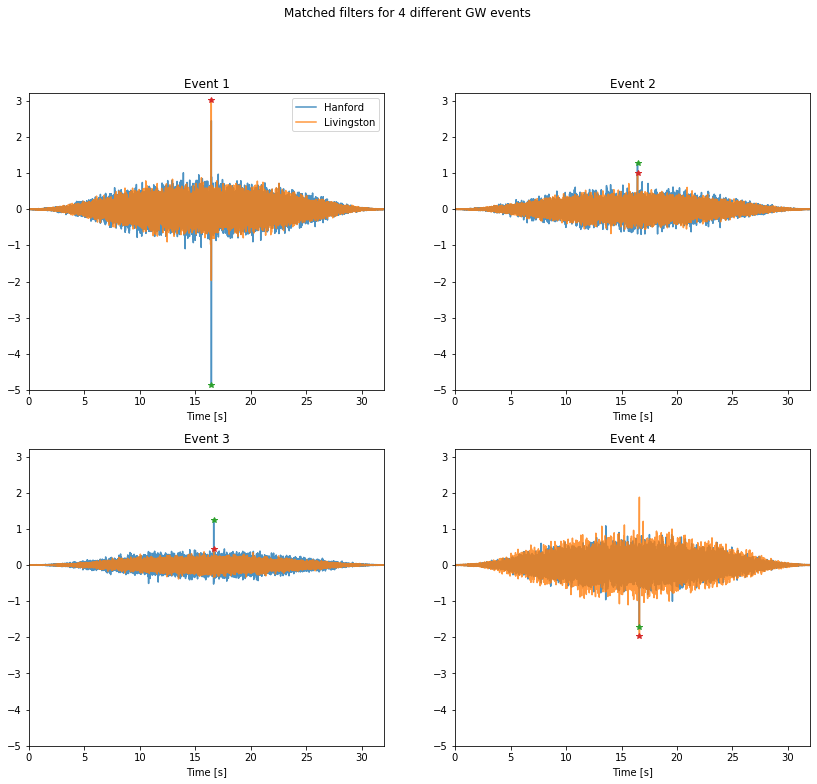

In [10]:
# Plot the matched filters from both instruments for each gravitational wave detection
fig, ax = plt.subplots(2, 2, figsize=(14,12))
fig.suptitle('Matched filters for 4 different GW events')

plot_matched_filter(ax[0,0], time_shifted, mf_H_1, mf_L_1, 'Event 1', idxs_H[0], idxs_L[0], legend=True)
plot_matched_filter(ax[0,1], time_shifted, mf_H_2, mf_L_2, 'Event 2', idxs_H[1], idxs_L[1])
plot_matched_filter(ax[1,0], time_shifted, mf_H_3, mf_L_3, 'Event 3', idxs_H[2], idxs_L[2])
plot_matched_filter(ax[1,1], time_shifted, mf_H_4, mf_L_4, 'Event 4', idxs_H[3], idxs_L[3])

plt.show()

### c) Signal-to-noise ratios
We can get a value for the SNR of the detection by comparing the amplitude of the matched filter peak to the amplitude of the noise near the time of the peak. I will consider the standard deviation of the matched filter in some domain following the peak as the noise amplitude.

In [11]:
# Get the asbolute values of the matched filter peaks
MF_peaks_H = np.abs(np.array([mf_H_1[idxs_H[0]], mf_H_2[idxs_H[1]], mf_H_3[idxs_H[2]], mf_H_4[idxs_H[3]]]))
MF_peaks_L = np.abs(np.array([mf_L_1[idxs_L[0]], mf_L_2[idxs_L[1]], mf_L_3[idxs_L[2]], mf_L_4[idxs_L[3]]]))

# Get the standard deviation of the matched filter over some time domain starting after the detection
# Take the standard deviation of 5000 points starting 1000 points after the detection (to ensure there are not gravitational wave remnants)
MF_noise_H = np.array([mf_H_1[idxs_H[0]+1000:idxs_H[0]+6000], mf_H_2[idxs_H[1]+1000:idxs_H[1]+6000],
                       mf_H_3[idxs_H[2]+1000:idxs_H[2]+6000], mf_H_4[idxs_H[3]+1000:idxs_H[3]+6000]])
MF_noise_L = np.array([mf_L_1[idxs_L[0]+1000:idxs_L[0]+6000], mf_L_2[idxs_L[1]+1000:idxs_L[1]+6000],
                       mf_L_3[idxs_L[2]+1000:idxs_L[2]+6000], mf_L_4[idxs_L[3]+1000:idxs_L[3]+6000]])

std_noise_H = np.std(MF_noise_H, axis=1)
std_noise_L = np.std(MF_noise_L, axis=1)

SNR_H = MF_peaks_H/std_noise_H
SNR_L = MF_peaks_L/std_noise_L

for i in range(4):
    print('Event {:d}: Hanford SNR is {:.1f}; Livingston SNR is {:.1f}'.format(i+1, SNR_H[i], SNR_L[i]))

Event 1: Hanford SNR is 19.0; Livingston SNR is 12.7
Event 2: Hanford SNR is 6.6; Livingston SNR is 5.3
Event 3: Hanford SNR is 9.5; Livingston SNR is 4.5
Event 4: Hanford SNR is 7.2; Livingston SNR is 6.3


We can also combine both strains to get another value for the SNR. To do this, I start by averaging the absolute values of both matched filters together, while ensuring they are correctly mapped to one another, and finding the SNR of the averaged filter.

In [12]:
# Map the noises onto one another.
noise_H_cut = np.array([mf_H_1[idxs_H[0]+1000:idxs_H[0]+6000], mf_H_2[idxs_H[1]+1000:idxs_H[1]+6000], 
                        mf_H_3[idxs_H[2]+1000:idxs_H[2]+6000], mf_H_4[idxs_H[3]+1000:idxs_H[3]+6000]])
noise_L_cut = np.array([mf_L_1[idxs_L[0]+1000:idxs_L[0]+6000], mf_L_2[idxs_L[1]+1000:idxs_L[1]+6000], 
                        mf_L_3[idxs_L[2]+1000:idxs_L[2]+6000], mf_L_4[idxs_L[3]+1000:idxs_L[3]+6000]])
# Average both noise strains together
noise_avg = (noise_H_cut+noise_L_cut)/2
# Get the standard deviation of the averaged noise strain
std_noise_avg = np.std(noise_avg, axis=1)

# Get the averaged peak from the absolute values of the peaks
peak_avg = [(MF_peaks_H[i]+MF_peaks_L[i])/2 for i in range(4)]

# Calculate the combined SNR
SNR_combined = peak_avg/std_noise_avg

for i in range(4):
    print('Event {:d}: Combined SNR is {:.1f}'.format(i+1, SNR_combined[i]))

Event 1: Combined SNR is 22.4
Event 2: Combined SNR is 8.4
Event 3: Combined SNR is 9.9
Event 4: Combined SNR is 9.5


### d) Compare to the analytic SNR
The analytic SNR can be calculate using the fact that the SNR is the signal over the noise.

\begin{aligned}
\text{SNR}^2 &= A^T N^{-1} A \\
\text{SNR}   &= \text{IFT}((\text{FT}(A)^* N^{-1} \text{FT}(A))^{1/2})
\end{aligned}

In [13]:
def SNR(template, noise):
    # Window the template
    template_win = template*np.hanning(len(template))
    # Fourier transform
    template_ft = np.fft.rfft(template_win)
    # Whiten data
    template_white = whiten(template, noise)
    
    # Calculate the SNR
    SNRsqr_ft = template_ft.conjugate()*template_ft/noise
    SNR_ft = np.sqrt(SNRsqr_ft)
    SNR = np.fft.irfft(SNR_ft)
    SNRmax = SNR.max()
    return SNRmax

In [14]:
for i in range(4):
    print('Event {:d}: Hanford SNR is {:.1f}; Livingston SNR is {:.1f}'.format(i+1, SNR(th[i,:], noise_H[i,:]), SNR(tl[i,:], noise_L[i,:])))

Event 1: Hanford SNR is 24.3; Livingston SNR is 21.7
Event 2: Hanford SNR is 16.5; Livingston SNR is 15.5
Event 3: Hanford SNR is 13.0; Livingston SNR is 10.4
Event 4: Hanford SNR is 20.8; Livingston SNR is 25.5


Clearly, the analytic SNRs disagree with the scatter SNRs. The analytic SNRs are all larger than their scatter-based counterparts. This is likely because the analytic SNR does not depend on how well the matched filter worked, but rather on the proper template (signal), and in some cases the matched filter did not work well at all (see Event 3, Livingston).

### e) Half-frequency

In [15]:
def half_freq(template, noise):
    # Window and whiten the template
    template_win = template*np.hanning(len(template))
    template_white = whiten(template_win, noise)
    template_white_ft = np.fft.rfft(template_white)
    
    # Get the cumulative sum of the power spectrum of the whitened template
    template_white_ft_cum = np.cumsum(np.abs(template_white_ft))
    
    # Find where it is equal to half of its maximum value
    diff = np.abs(template_white_ft_cum - template_white_ft_cum.max()/2) # vector of distances from the half value
    idx = np.where(diff == diff.min())[0][0]
    freq_half = freq[idx]    
    return freq_half    

In [16]:
for i in range(4):
    print('Event {:d}: half-frequency value for Hanford is {:.2f} Hz, and it is {:.2f} Hz for Livingston.'.format(i+1, half_freq(th[i,:], noise_H[i,:]), half_freq(tl[i,:], noise_L[i,:])))

Event 1: half-frequency value for Hanford is 124.69 Hz, and it is 133.62 Hz for Livingston.
Event 2: half-frequency value for Hanford is 114.69 Hz, and it is 129.22 Hz for Livingston.
Event 3: half-frequency value for Hanford is 132.34 Hz, and it is 172.06 Hz for Livingston.
Event 4: half-frequency value for Hanford is 124.78 Hz, and it is 113.16 Hz for Livingston.


### f) Localization of the gravitational waves in time
Because the instruments are separated by ~1000km and gravitational waves travel at the speed of light, we should expect a positional uncertainty in time on the order of $\delta t \sim \frac{1000\text{km}}{c} \approx 0.003$ s.

The time differences for these particular events are:

In [17]:
# Print the difference between the arrival time of the gravitational waves at each instrument.
for i in range(4):
    print('Event {:d}: t_Hanford - t_Livingston = {:.5f} s'.format(i+1, time_shifted[idxs_H[i]]-time_shifted[idxs_L[i]]))

Event 1: t_Hanford - t_Livingston = 0.00879 s
Event 2: t_Hanford - t_Livingston = -0.00195 s
Event 3: t_Hanford - t_Livingston = -0.00024 s
Event 4: t_Hanford - t_Livingston = -0.00488 s


### Appendix: Detected gravitational waves

In [18]:
def plot_gw(strain_H, strain_L, th, tl, idx_H, idx_L, i, scaling1, scaling2, xmin, xmax):
    time = np.arange(0, len(strain_H)*dt, dt)
    time_shifted = np.fft.fftshift(time)
    
    f, ax = plt.subplots(2, 1, sharex=True, figsize=(10,5))
    
    ax[0].set_title('Event '+repr(i+1))
    ax[0].set_ylabel('Hanford')
    ax[0].plot(time, strain_H, alpha=0.5)
    ax[0].plot(time+time[idx_H], scaling1*th*np.blackman(len(th)), 'b')
    ymin, ymax = ax[0].get_ylim()
    ax[0].vlines(time_shifted[idx_H],ymin,ymax,'k','dashed')
    ax[0].set_ylim(ymin, ymax)
    
    ax[1].set_ylabel('Livingston')
    ax[1].plot(time, np.roll(strain_L, -(idx_L-idx_H)), 'g', alpha=0.5)
    ax[1].plot(time+time[idx_L], np.roll(scaling2*tl*np.blackman(len(tl)), -(idx_L-idx_H)), 'darkgreen')
    ymin, ymax = ax[1].get_ylim()
    ax[1].vlines(time_shifted[idx_L],ymin,ymax,'k','dashed')
    ax[1].set_ylim(ymin, ymax)
    ax[1].set_xlim(xmin, xmax)
    
    plt.subplots_adjust(hspace=0)
    plt.show()

In [19]:
Hstrains = np.zeros([4, len(strain_H[0,:])])
Lstrains = np.zeros([4, len(strain_L[0,:])])
for i in range(4):
    Hstrains[i,:] = whiten(strain_H[i,:]*np.hanning(len(strain_H[i,:])), noise_H[i,:])
    Lstrains[i,:] = whiten(strain_L[i,:]*np.hanning(len(strain_L[i,:])), noise_L[i,:])

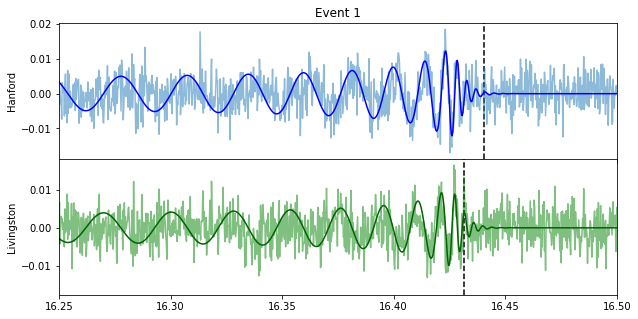

In [20]:
i = 0
plot_gw(Hstrains[i,:], Lstrains[i,:], th[i,:], tl[i,:], idxs_H[i], idxs_L[i], i, -1.5e16, 1.2e16, 16.25, 16.5)

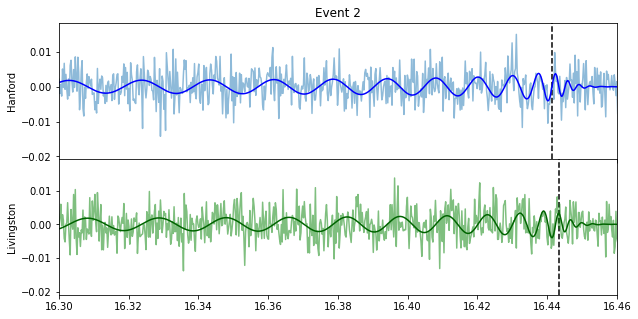

In [21]:
i = 1
plot_gw(Hstrains[i,:], Lstrains[i,:], th[i,:], tl[i,:], idxs_H[i], idxs_L[i], i, 1e16, 1e16, 16.30, 16.46)

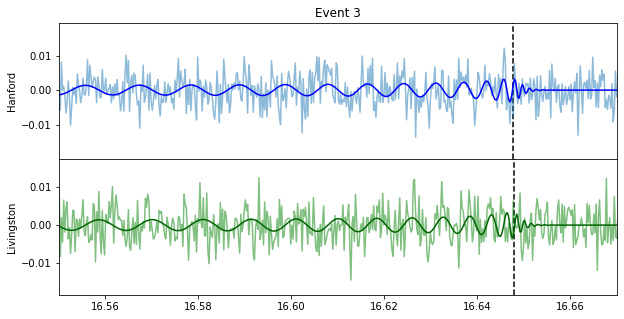

In [22]:
i = 2
plot_gw(Hstrains[i,:], Lstrains[i,:], th[i,:], tl[i,:], idxs_H[i], idxs_L[i], i, 1.5e16, 1.5e16, 16.55, 16.67)

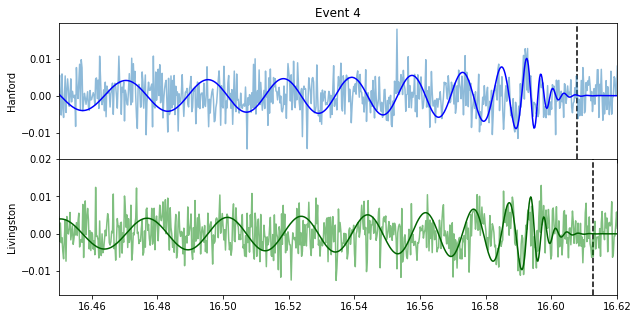

In [23]:
i = 3
plot_gw(Hstrains[i,:], Lstrains[i,:], th[i,:], tl[i,:], idxs_H[i], idxs_L[i], i, -1.5e16, -1.5e16, 16.45, 16.62)